In [14]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import comet_ml
from comet_ml import Experiment

In [16]:
import os,sys
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CometLogger

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Wedge, Polygon
import matplotlib
from matplotlib.patches import ConnectionPatch
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams.update({'font.size': 18})

In [18]:
sys.path.append('../training')
from manifoldembedder import *
from anomalymodels import *

In [19]:
import matplotlib as mpl
import matplotlib.font_manager as font_manager

mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
mpl.rcParams['figure.dpi'] = 300

import matplotlib.pyplot as plt


In [20]:
basedir = '/nobackup/users/sangeon/datasets/jetGridpack/jetpairs'


In [21]:
file_dict = {'train':os.path.join(basedir, 'Gridpack_jettrain_16part_merged.pt'),
             'val':os.path.join(basedir, 'Gridpack_jetval_16part_merged.pt'),
             'test':None,
             'predict':os.path.join(basedir, 'taus_Gridpack_jetpair_predict.pt')}

In [22]:
trainer = Trainer(gpus=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [23]:
jetsim_dm = JetDataModule(file_dict,2500)


In [24]:
#embedder = ManifoldEmbedder.load_from_checkpoint("../training/simulatedtoyjets_checkpoints/Transformer-paper-v0-checkpoint-epoch=01-val_loss=0.55.ckpt")

In [25]:
embedder = ManifoldEmbedder.load_from_checkpoint("../training/simulatedtoyjets_checkpoints/Transformer-paper-finaltuning-try14-epoch=00-val_loss=0.27.ckpt")

In [26]:
#embedder = ManifoldEmbedder.load_from_checkpoint("../training/simulatedtoyjets_checkpoints/Transformer-paper-finaltuning-try6-epoch=00-val_loss=0.28.ckpt")

In [27]:
embedder.eval()


ManifoldEmbedder(
  (encoder): particleTransformer(
    (embed_src): Linear(in_features=3, out_features=32, bias=True)
    (embed_tgt): Linear(in_features=3, out_features=32, bias=True)
    (pos_enc): PositionalEncoding(
      (dropout): Dropout(p=0.25, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=32, out_features=32, bias=True)
          )
          (linear1): Linear(in_features=32, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=32, bias=True)
          (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): Tra

In [28]:
a = trainer.predict(embedder, jetsim_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/nobackup/users/sangeon/condas/anaconda3/envs/studies/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

/nobackup/users/sangeon/condas/anaconda3/envs/studies/lib/python3.8/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:172: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


In [29]:
label = np.array([])
embedding = np.empty((0,2))
for batch in a:
    #print(batch[0].shape)
    #print(batch[1].shape)
    embedding = np.vstack((embedding, batch[0].cpu().numpy()))
    label = np.concatenate([label, batch[1].cpu().numpy()])
    #print(batch[0], batch[1])

In [30]:
embedding

array([[ 0.05150989,  0.03534313],
       [ 0.10505687,  0.07868888],
       [ 0.05455929,  0.02680699],
       ...,
       [-0.09113473,  0.13170011],
       [ 0.06708828,  0.24460465],
       [ 0.29873449,  0.25175232]])

In [31]:
namelist = ['QCD','2p25','2p170','3p25','3p170','4p170','4p400']


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for i in range(7):
    ax.scatter(embedding[label==i][:1000,0],embedding[label==i][:1000,1],s=10,alpha=0.20,label=namelist[i])

ax.set_xlabel('Embed Dimension 1')
ax.set_ylabel('Embed Dimension 2')
ax.set_xlim([-0.4,0.0])
ax.set_ylim([0.12,0.22])
leg = ax.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
ax.set_title('Simulated Jet Embedding')    
fig.savefig(f'../figures/paper/embedding_simulated_toyjet_final_v1.png')    
fig.savefig(f'../figures/paper/embedding_simulated_toyjet_final_v1.pdf')

In [33]:
plt.rcParams.update({'font.size': 17})

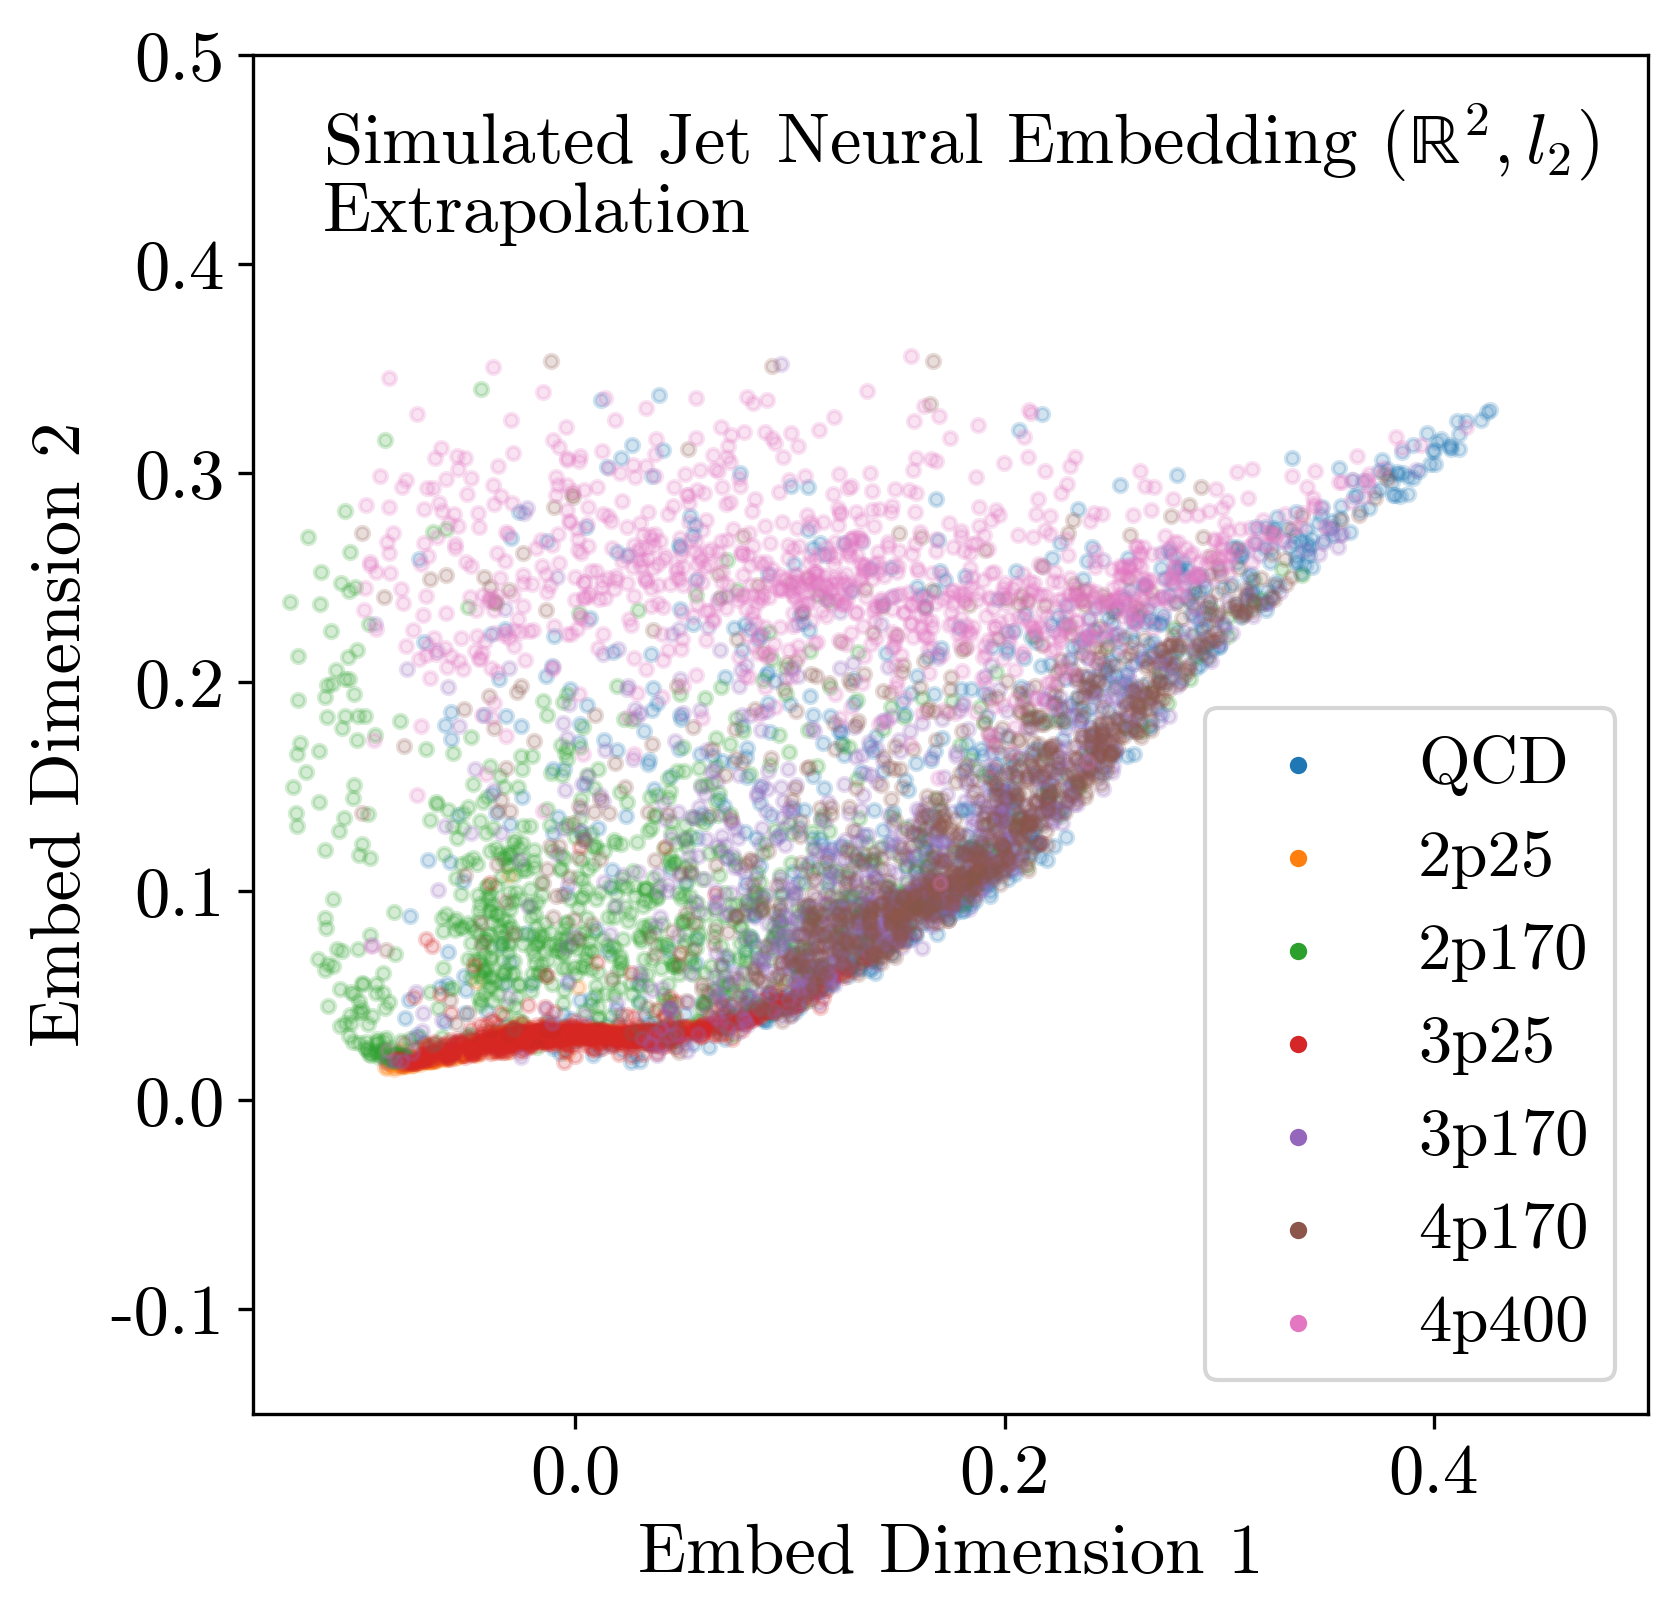

In [42]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for i in range(7):
    ax.scatter(embedding[label==i][:1000,0],embedding[label==i][:1000,1],s=10,alpha=0.20,label=namelist[i])

ax.set_xlabel('Embed Dimension 1')
ax.set_ylabel('Embed Dimension 2')
ax.set_xlim([-0.15,0.5])
ax.set_ylim([-0.15,0.5])
leg = ax.legend(fontsize=16)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    


ax.text(.05,.92, r'Simulated Jet Neural Embedding $(\mathrm{\mathbb{R}}^2, l_2)$',transform=ax.transAxes)    
ax.text(.05,.87, r'Extrapolation',transform=ax.transAxes)    

fig.savefig(f'../figures/paper_JHEP/SimulatedJet_Embedding_ScatterPlot.png')    
fig.savefig(f'../figures/paper_JHEP/SimulatedJet_Embedding_ScatterPlot.pdf')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for i in range(7):
    ax.scatter(embedding[label==i][:1000,0],embedding[label==i][:1000,1],s=10,alpha=0.20,label=namelist[i])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim([-0.1,0.6])
ax.set_ylim([-0.6,0.1])
leg = ax.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
ax.set_title('Simulated Jet Embedding')    
fig.savefig(f'../figures/paper/embedding_simulated_toyjet_final_v3.png')    
fig.savefig(f'../figures/paper/embedding_simulated_toyjet_final_v3.pdf')

In [36]:
from sklearn.neighbors import KernelDensity
from scipy import interpolate

def kde2D(x, y, bandwidth, xbins=100j, ybins=100j, **kwargs): 
    """Build 2D kernel density estimate (KDE)."""
    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[-0.15:0.5:xbins, 
                      -0.15:0.5:ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx, yy, np.reshape(z, xx.shape)

In [37]:
def plot_KDE_cdf_contour(ax, whichlabel, cdfval, color):
    xx, yy, zz = kde2D(embedding[label==whichlabel][:,0], embedding[label==whichlabel][:,1], .005, kernel='gaussian')
    hist = zz/zz.sum()
    n = 1000
    t = np.linspace(0, hist.max(), n)
    integral = ((hist >= t[:, None, None]) * hist).sum(axis=(1,2))
    f = interpolate.interp1d(integral, t)
    t_contours = f(np.array(cdfval))
    
    #ax.imshow(hist.T, origin='lower', extent=[-0.1, 0.4, -0.05, 0.35], cmap="gray",aspect='auto')
    CS = ax.contour(hist.T, t_contours, extent=[-0.15,0.5, -0.15,0.5],colors=color, alpha=0.8)
    
    #fig.set_size_inches(8, 8)
    return CS
    

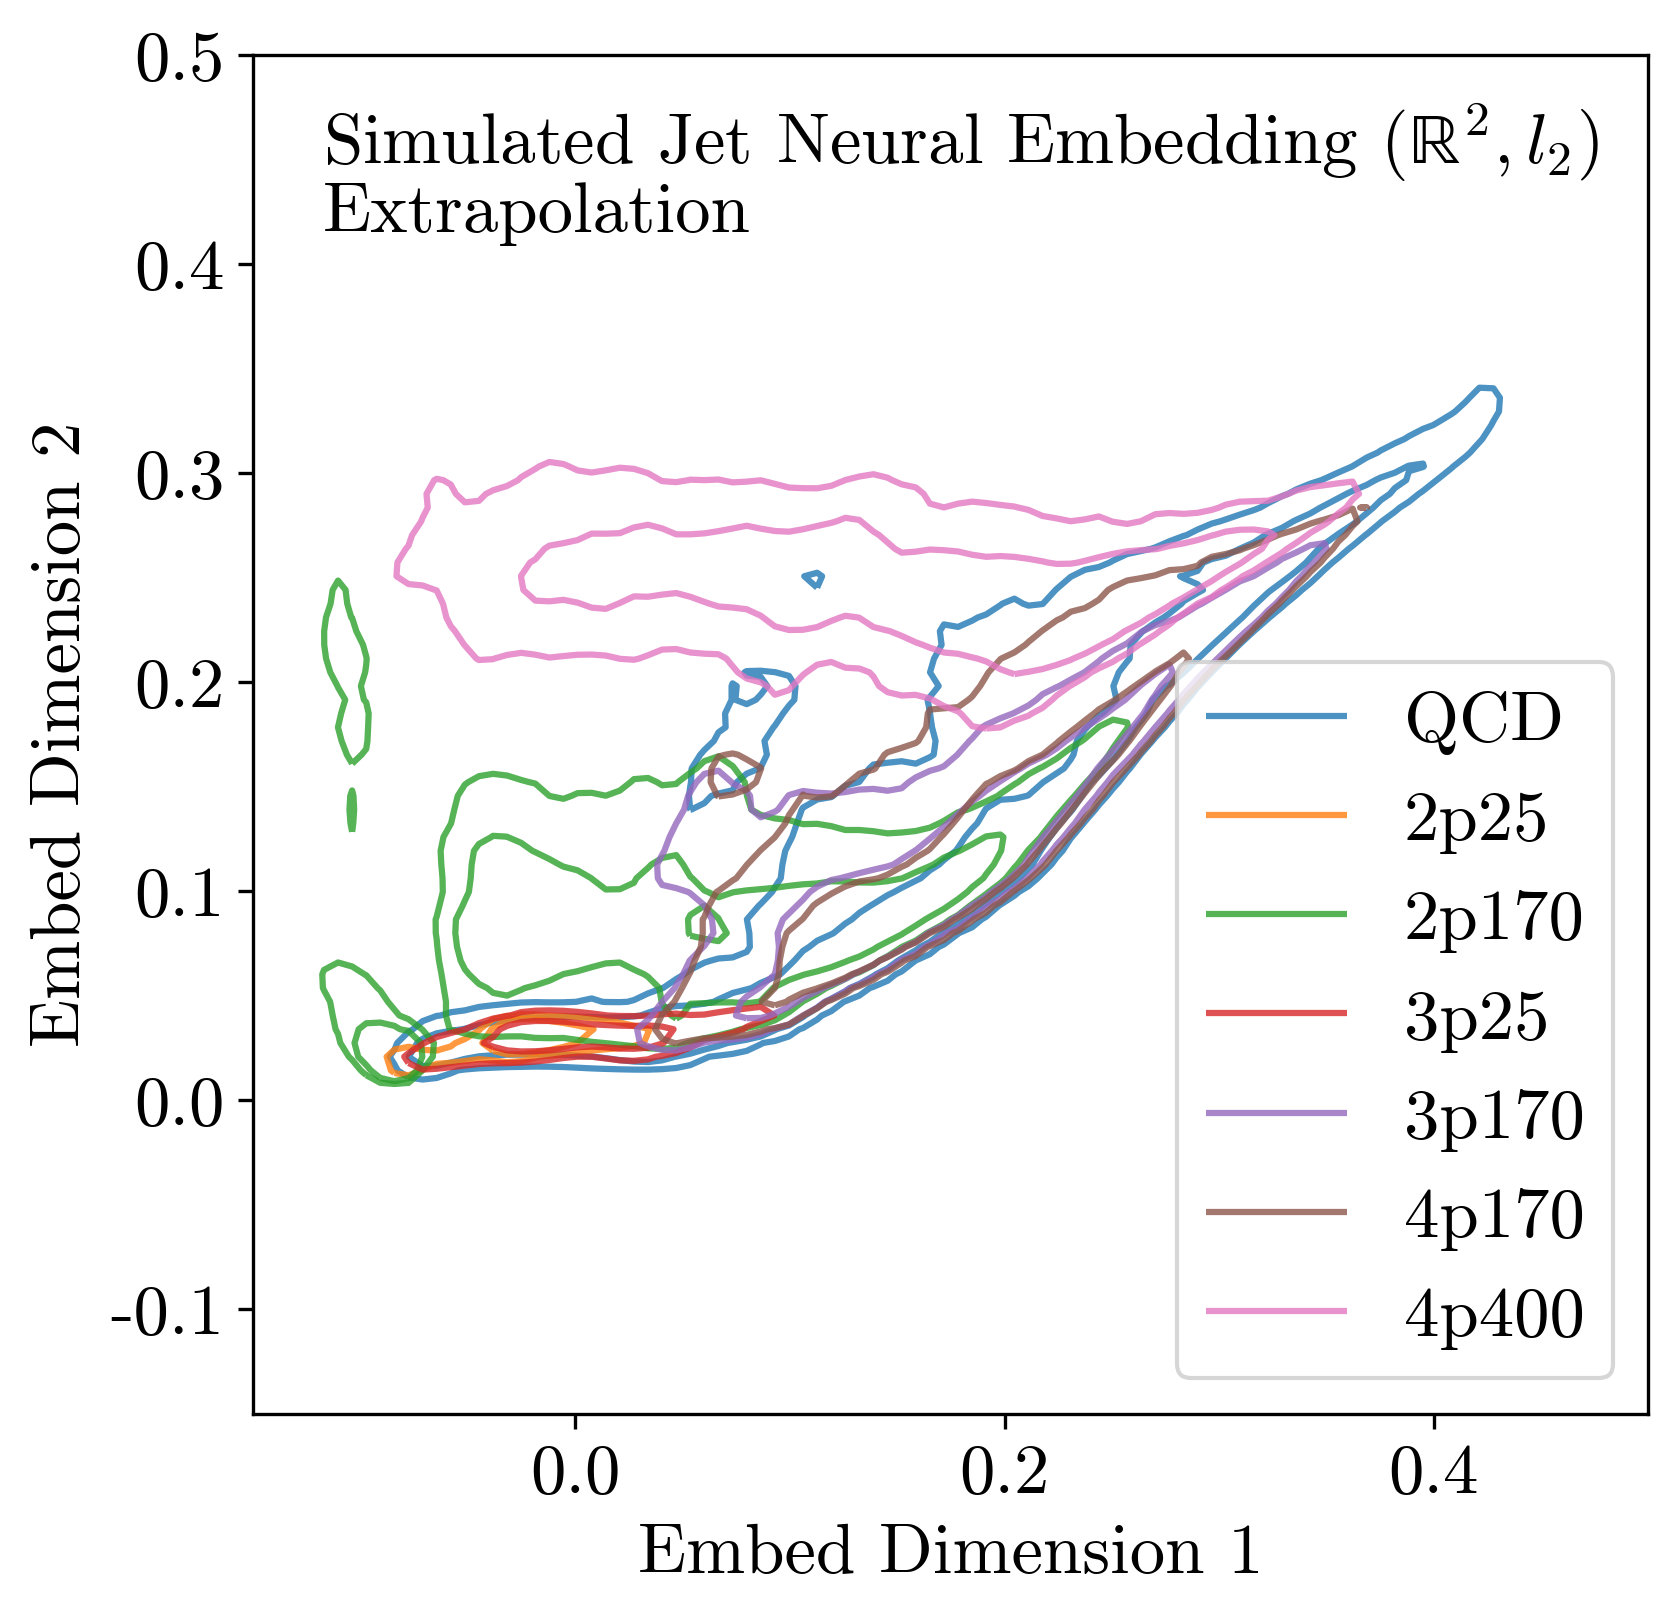

In [38]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
lines = []
for i in range(0,7):
    CS = plot_KDE_cdf_contour(ax, i,[0.8,0.5], f'C{i}')
    lines.append(CS.collections[0])


ax.set_xlabel('Embed Dimension 1')
ax.set_ylabel('Embed Dimension 2')
ax.set_xlim([-0.15,0.5])
ax.set_ylim([-0.15,0.5])
ax.legend(lines, namelist,loc='lower right',fontsize=16)

ax.text(.05,.92, r'Simulated Jet Neural Embedding $(\mathrm{\mathbb{R}}^2, l_2)$',transform=ax.transAxes)    
ax.text(.05,.87, r'Extrapolation',transform=ax.transAxes)    

fig.savefig(f'../figures/paper_JHEP/SimulatedJet_Embedding_ContourPlot.png')    
fig.savefig(f'../figures/paper_JHEP/SimulatedJet_Embedding_ContourPlot.pdf')

In [43]:
with open(f'/nobackup/users/sangeon/datasets/jetGridpack/jetpairs/taus_Gridpack_jetpair_predict_extrafeats.pickle','rb') as handle:
    extrafeats = pickle.load(handle)

In [44]:
column_names = ['particle 0 pt', 'particle 0 eta', 'particle 0 phi', 'particle 1 pt',
       'particle 1 eta', 'particle 1 phi', 'particle 2 pt', 'particle 2 eta',
       'particle 2 phi', 'particle 3 pt', 'particle 3 eta', 'particle 3 phi',
       'particle 4 pt', 'particle 4 eta', 'particle 4 phi', 'particle 5 pt',
       'particle 5 eta', 'particle 5 phi', 'particle 6 pt', 'particle 6 eta',
       'particle 6 phi', 'particle 7 pt', 'particle 7 eta', 'particle 7 phi',
       'particle 8 pt', 'particle 8 eta', 'particle 8 phi', 'particle 9 pt',
       'particle 9 eta', 'particle 9 phi', 'particle 10 pt', 'particle 10 eta',
       'particle 10 phi', 'particle 11 pt', 'particle 11 eta',
       'particle 11 phi', 'particle 12 pt', 'particle 12 eta',
       'particle 12 phi', 'particle 13 pt', 'particle 13 eta',
       'particle 13 phi', 'particle 14 pt', 'particle 14 eta',
       'particle 14 phi', 'particle 15 pt', 'particle 15 eta',
       'particle 15 phi', 'jet pT', 'jet eta', 'jet phi', 'jet mass',
       'jet mmdt', 'jet softdrop', 'jet tau21', 'jet tau32', 'jet tau43',
       'jet tau54', 'jet tau65', 'jet tau76', 'jet tau87',
       'jet sqrt_t1_b2_t1_b2']

In [45]:
column_names[48:]

['jet pT',
 'jet eta',
 'jet phi',
 'jet mass',
 'jet mmdt',
 'jet softdrop',
 'jet tau21',
 'jet tau32',
 'jet tau43',
 'jet tau54',
 'jet tau65',
 'jet tau76',
 'jet tau87',
 'jet sqrt_t1_b2_t1_b2']

In [46]:
extrafeats.shape

(700000, 14)

In [47]:
extrafeats.shape

(700000, 14)

In [48]:
embedding.shape

(700000, 2)

In [49]:
colorlist = ['C0','C1','C2','C3','C4','C5','C6']

In [50]:
namelist

['QCD', '2p25', '2p170', '3p25', '3p170', '4p170', '4p400']

In [51]:
def plot_circle_and_fill_hist(ax_i, ax_j1, ax_j2, ax_j3, center, radius, color, whichlabel):
    bins = np.linspace(0,1,51)
    circle1 = Circle(center, radius, color=color, alpha=0.35)
    diff = embedding - np.tile(np.array(center), (700000,1))
    dist = np.sqrt(np.sum(diff*diff, axis =1))
    indices = np.where(dist<radius)
    selected_feats = extrafeats[indices[0]]
    labelselected = label[indices[0]]
    ax_i.add_patch(circle1)
    
    #ax_j1.hist(selected_feats[:,8],density=True,alpha=0.3, label='original mixture',color='grey',bins=bins)
    for i in whichlabel:
        print(i, selected_feats[labelselected==i,-1].shape)
        if namelist[i] == 'QCD':
            alpha = 0.7
        else:
            alpha = 0.3
        ax_j1.hist(selected_feats[labelselected==i,8],density=True,alpha=alpha, label=f'Selected {namelist[i]}',color=colorlist[i],bins=bins)
    ax_j1.set_xlabel(r'$\tau_{43}$', fontsize=20)
    ax_j1.set_ylabel(r'Density', fontsize=20)
    ax_j1.legend(fontsize=14)
    
    #ax_j2.hist(selected_feats[:,6],density=True,alpha=0.3, label='original mixture',color='grey',bins=bins)
    for i in whichlabel:
        print(i, selected_feats[labelselected==i,-1].shape)
        if namelist[i] == 'QCD':
            alpha = 0.7
        else:
            alpha = 0.3
        ax_j2.hist(selected_feats[labelselected==i,6],density=True,alpha=alpha, label=f'Selected {namelist[i]}',color=colorlist[i],bins=bins)
    ax_j2.set_xlabel(r'$\tau_{21}$', fontsize=20)
    ax_j2.set_ylabel(r'Density', fontsize=20)
    ax_j2.legend(fontsize=14)
    
    
    #ax_j3.hist(selected_feats[:,7],density=True,alpha=0.3, label='original mixture',color='grey',bins=bins)
    for i in whichlabel:
        print(i, selected_feats[labelselected==i,-1].shape)
        if namelist[i] == 'QCD':
            alpha = 0.7
        else:
            alpha = 0.3
        ax_j3.hist(selected_feats[labelselected==i,7],density=True,alpha=alpha, label=f'Selected {namelist[i]}',color=colorlist[i],bins=bins)
    ax_j3.set_xlabel(r'$\tau_{32}$', fontsize=20)
    ax_j3.set_ylabel(r'Density', fontsize=20)
    ax_j3.legend(fontsize=14)

    return None

    

In [52]:
#plt.rcParams.update({'font.size': 16})

0 (7929,)
4 (3513,)
5 (4212,)
6 (5219,)
0 (7929,)
4 (3513,)
5 (4212,)
6 (5219,)
0 (7929,)
4 (3513,)
5 (4212,)
6 (5219,)
0 (11185,)
2 (6375,)
4 (22878,)
5 (23723,)
0 (11185,)
2 (6375,)
4 (22878,)
5 (23723,)
0 (11185,)
2 (6375,)
4 (22878,)
5 (23723,)
0 (9474,)
1 (56050,)
2 (2819,)
3 (56691,)
0 (9474,)
1 (56050,)
2 (2819,)
3 (56691,)
0 (9474,)
1 (56050,)
2 (2819,)
3 (56691,)


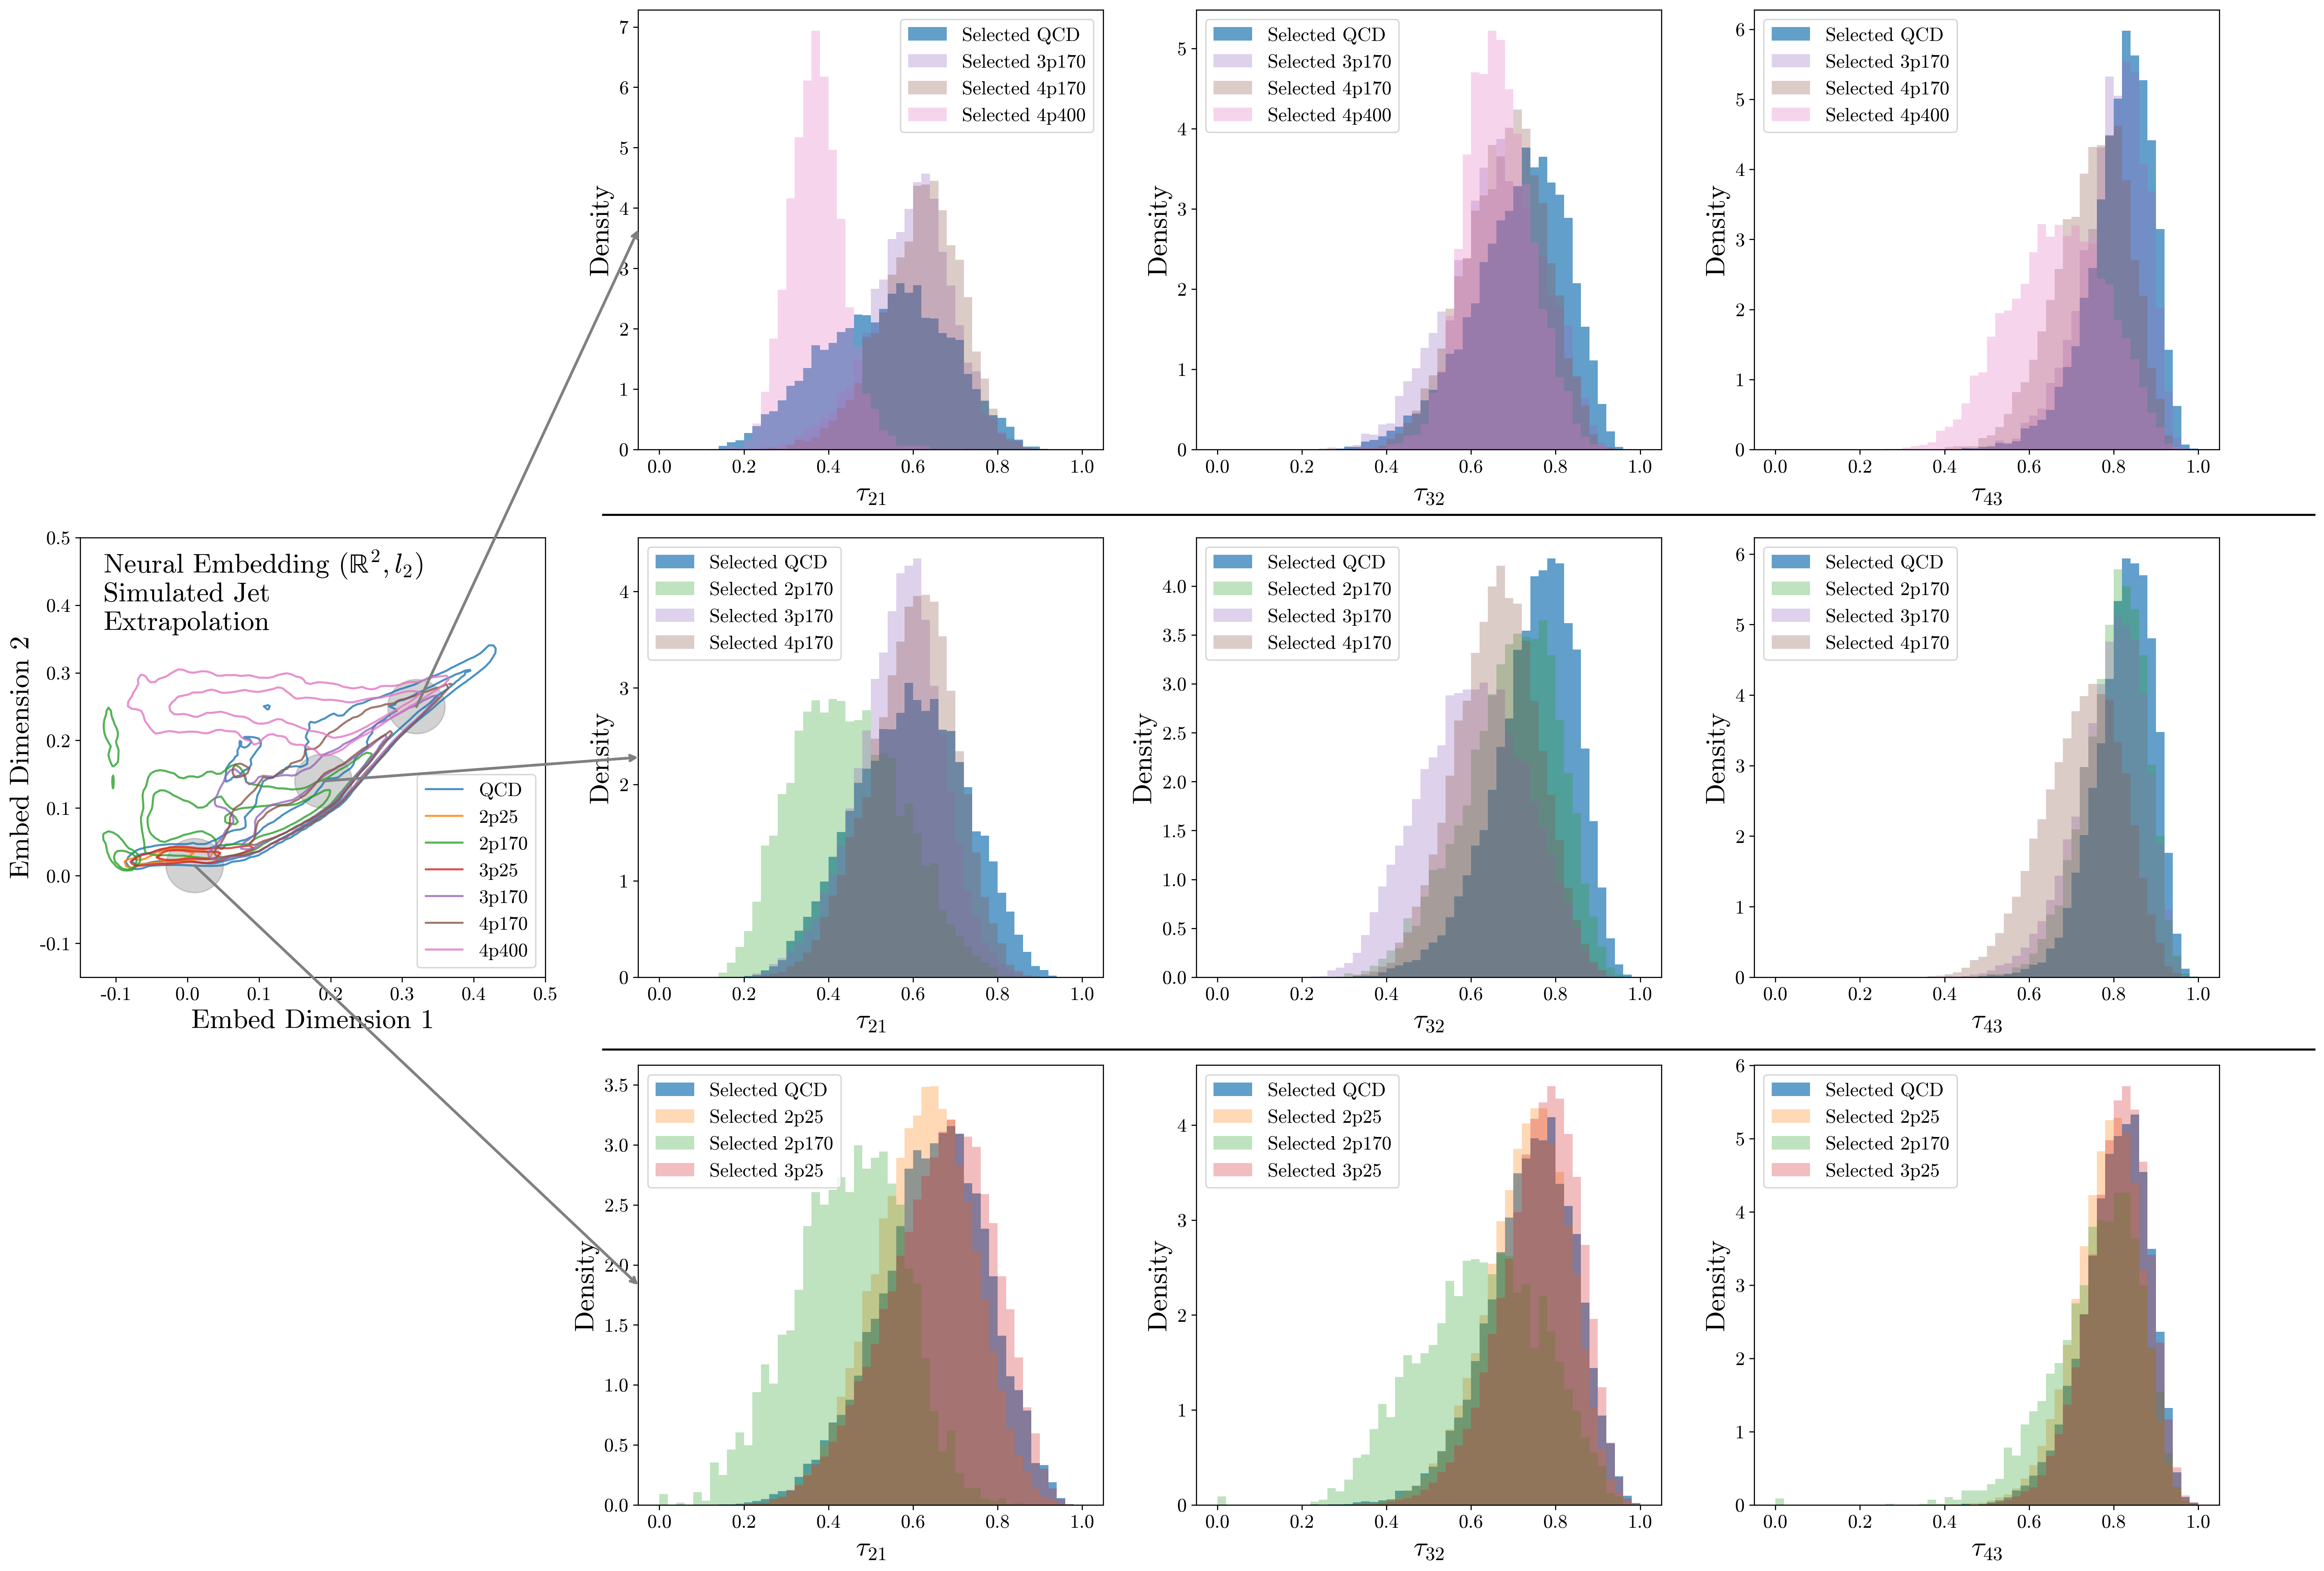

In [43]:
fig = plt.figure(constrained_layout=False, facecolor='1.',  figsize=(24,20))
gs = fig.add_gridspec(nrows=3, ncols=4, left=0.05, right=.95,
                      hspace=0.2, wspace=0.2)
ax0 = fig.add_subplot(gs[1, 0])

lines = []
for i in range(7):
    CS = plot_KDE_cdf_contour(ax0, i,[0.8,0.5], f'C{i}')
    lines.append(CS.collections[0])


ax0.set_xlabel('Embed Dimension 1', fontsize=20)
ax0.set_ylabel('Embed Dimension 2', fontsize=20)
ax0.set_xlim([-0.15,0.5])
ax0.set_ylim([-0.15,0.5])
ax0.legend(lines, namelist, loc='lower right')
ax0.text(.05,.92, r'Neural Embedding $(\mathrm{\mathbb{R}}^2, l_2)$',transform=ax0.transAxes, fontsize=20)    
ax0.text(.05,.855, r'Simulated Jet',transform=ax0.transAxes, fontsize=20)    
ax0.text(.05,.790, r'Extrapolation',transform=ax0.transAxes, fontsize=20)    


ax1 = fig.add_subplot(gs[0, 1])

ax2 = fig.add_subplot(gs[1, 1])

ax3 = fig.add_subplot(gs[2, 1])

ax4 = fig.add_subplot(gs[0, 2])

ax5 = fig.add_subplot(gs[1, 2])

ax6 = fig.add_subplot(gs[2, 2])

ax7 = fig.add_subplot(gs[0, 3])

ax8 = fig.add_subplot(gs[1, 3])

ax9 = fig.add_subplot(gs[2, 3])
plot_circle_and_fill_hist(ax0, ax7, ax1, ax4,  (0.32,0.25), 0.04,'grey',[0,4,5,6])
plot_circle_and_fill_hist(ax0, ax8, ax2, ax5,  (0.19,0.14), 0.04,'grey',[0,2,4,5])
plot_circle_and_fill_hist(ax0, ax9, ax3, ax6,  (0.01,0.015), 0.04,'grey',[0,1,2,3])


con = ConnectionPatch(xyA=(0.32,0.25), xyB=(0,0.5), coordsA="data", coordsB="axes fraction",
                              axesA=ax0, axesB=ax1, color="grey", lw=2, arrowstyle='->')
fig.add_artist(con)
con = ConnectionPatch(xyA=(0.19,0.14), xyB=(0,0.5), coordsA="data", coordsB="axes fraction",
                              axesA=ax0, axesB=ax2, color="grey", lw=2, arrowstyle='->')
fig.add_artist(con)
con = ConnectionPatch(xyA=(0.01,0.015), xyB=(0,0.5), coordsA="data", coordsB="axes fraction",
                              axesA=ax0, axesB=ax3, color="grey", lw=2, arrowstyle='->')
fig.add_artist(con)

ys = [0.355,0.625]
for y in ys:
    line = plt.Line2D([0.27,0.99],[y,y], transform=fig.transFigure, color="black")
    fig.add_artist(line)

In [44]:
fig.savefig(f'../figures/paper_JHEP/SimulatedJet_WhatIsLearned.png')    
fig.savefig(f'../figures/paper_JHEP/SimulatedJet_WhatIsLearned.pdf')    

In [53]:
file_dict = {'train':os.path.join(basedir, 'Gridpack_jettrain_16part_merged.pt'),
             'val':os.path.join(basedir, 'Gridpack_jetval_16part_merged.pt'),
             'test':None,
             'predict':os.path.join(basedir, 'interpolate_Gridpack_jetpair_predict.pt')}

In [54]:
interpolate_dm = JetDataModule(file_dict,2500)


In [55]:
a = trainer.predict(embedder, interpolate_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/nobackup/users/sangeon/condas/anaconda3/envs/studies/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [56]:
label = np.array([])
embedding = np.empty((0,2))
for batch in a:
    #print(batch[0].shape)
    #print(batch[1].shape)
    embedding = np.vstack((embedding, batch[0].cpu().numpy()))
    label = np.concatenate([label, batch[1].cpu().numpy()])
    #print(batch[0], batch[1])

In [57]:
label

array([0., 0., 0., ..., 4., 4., 4.])

In [58]:
namelist = ['QCD','2p80','2p400','3p80','3p400']


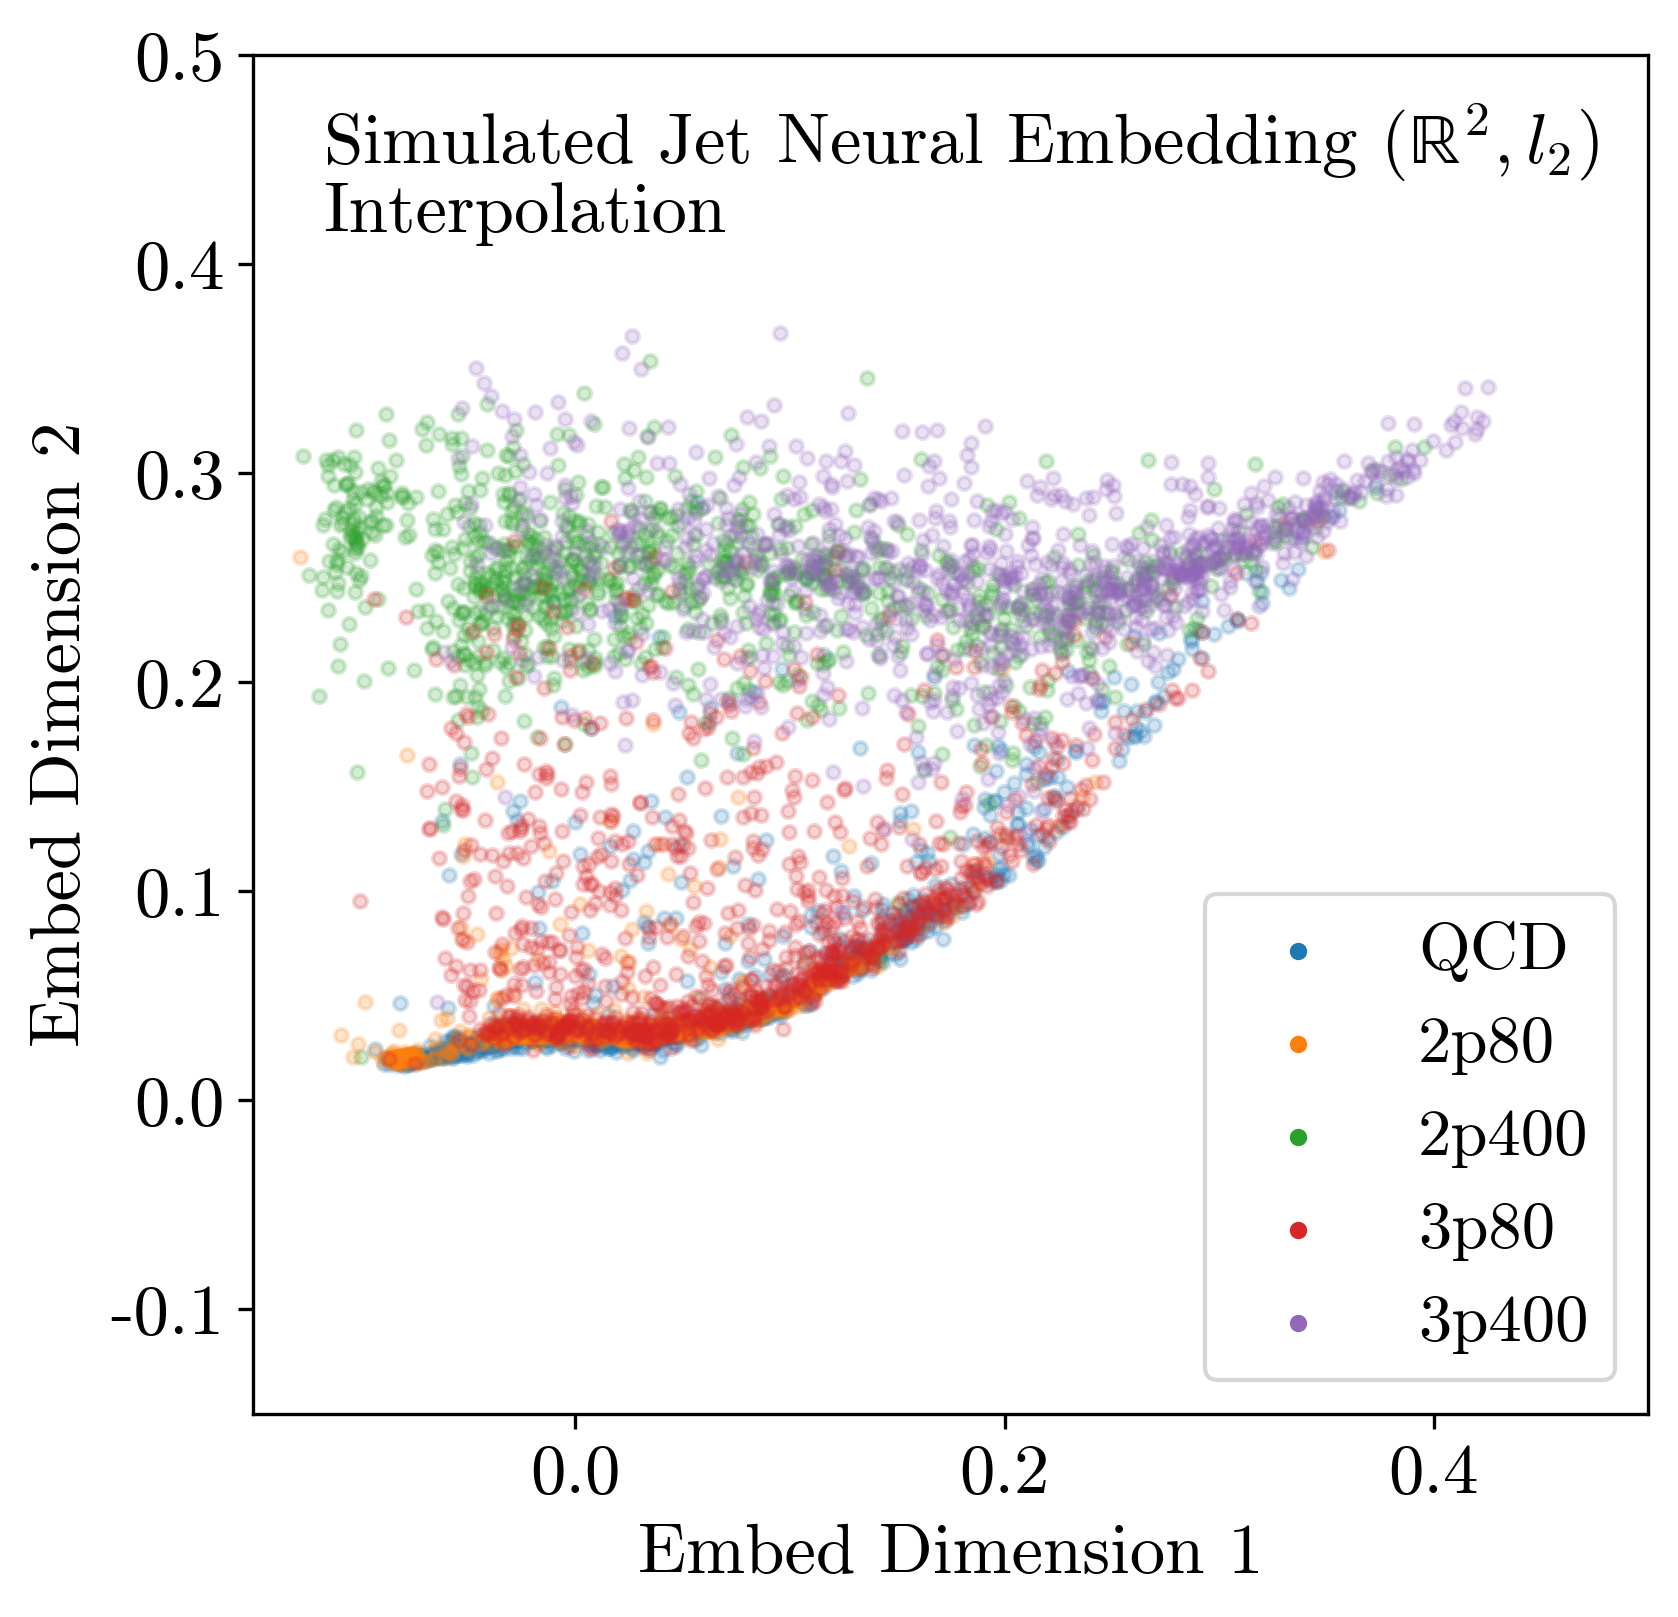

In [60]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for i in range(5):
    ax.scatter(embedding[label==i][:1000,0],embedding[label==i][:1000,1],s=10,alpha=0.20,label=namelist[i])

ax.set_xlabel('Embed Dimension 1')
ax.set_ylabel('Embed Dimension 2')
ax.set_xlim([-0.15,0.5])
ax.set_ylim([-0.15,0.5])
leg = ax.legend(fontsize=16)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
ax.text(.05,.92, r'Simulated Jet Neural Embedding $(\mathrm{\mathbb{R}}^2, l_2)$',transform=ax.transAxes)    
ax.text(.05,.87, r'Interpolation',transform=ax.transAxes)    

fig.savefig(f'../figures/paper_JHEP/SimulatedJet_Interpolate_Embedding_ScatterPlot.png')    
fig.savefig(f'../figures/paper_JHEP/SimulatedJet_Interpolate_Embedding_ScatterPlot.pdf')

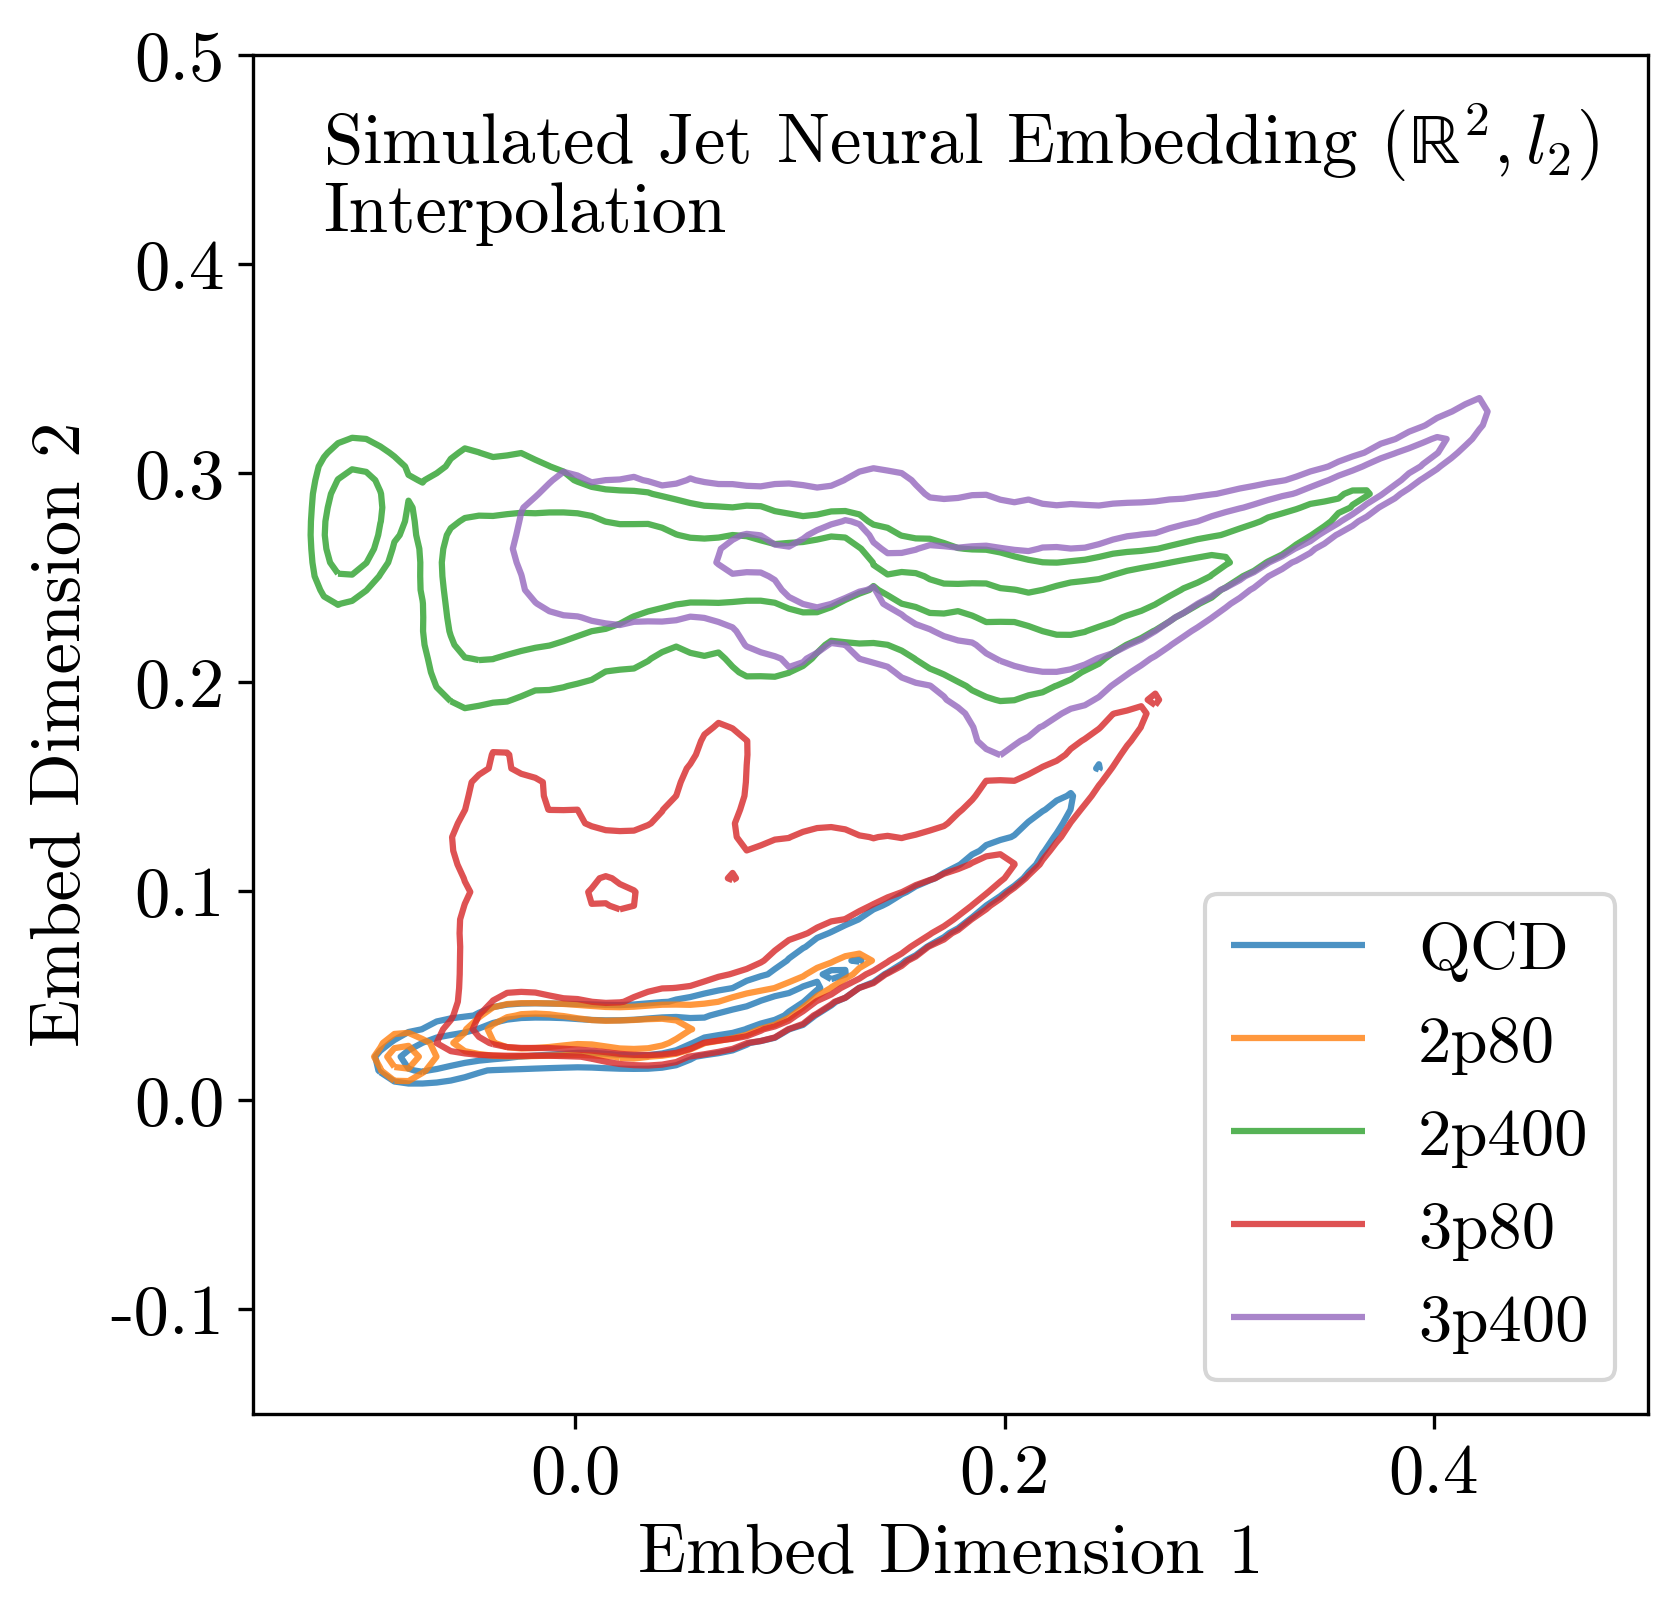

In [61]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
lines = []
for i in range(0,5):
    CS = plot_KDE_cdf_contour(ax, i,[0.8,0.5], f'C{i}')
    lines.append(CS.collections[0])


ax.set_xlabel('Embed Dimension 1')
ax.set_ylabel('Embed Dimension 2')
ax.set_xlim([-0.15,0.5])
ax.set_ylim([-0.15,0.5])
ax.legend(lines, namelist,loc='lower right',fontsize=16)

ax.text(.05,.92, r'Simulated Jet Neural Embedding $(\mathrm{\mathbb{R}}^2, l_2)$',transform=ax.transAxes)    
ax.text(.05,.87, r'Interpolation',transform=ax.transAxes)    

fig.savefig(f'../figures/paper_JHEP/SimulatedJet_Interpolate_Embedding_ContourPlot.png')    
fig.savefig(f'../figures/paper_JHEP/SimulatedJet_Interpolate_Embedding_ContourPlot.pdf')

0 (4992,)
4 (4946,)
5 (6312,)
6 (9144,)
0 (4992,)
4 (4946,)
5 (6312,)
6 (9144,)
0 (4992,)
4 (4946,)
5 (6312,)
6 (9144,)
0 (1699,)
2 (3616,)
4 (4820,)
5 (4055,)
0 (1699,)
2 (3616,)
4 (4820,)
5 (4055,)
0 (1699,)
2 (3616,)
4 (4820,)
5 (4055,)
1 (2721,)
3 (1834,)
1 (2721,)
3 (1834,)
1 (2721,)
3 (1834,)


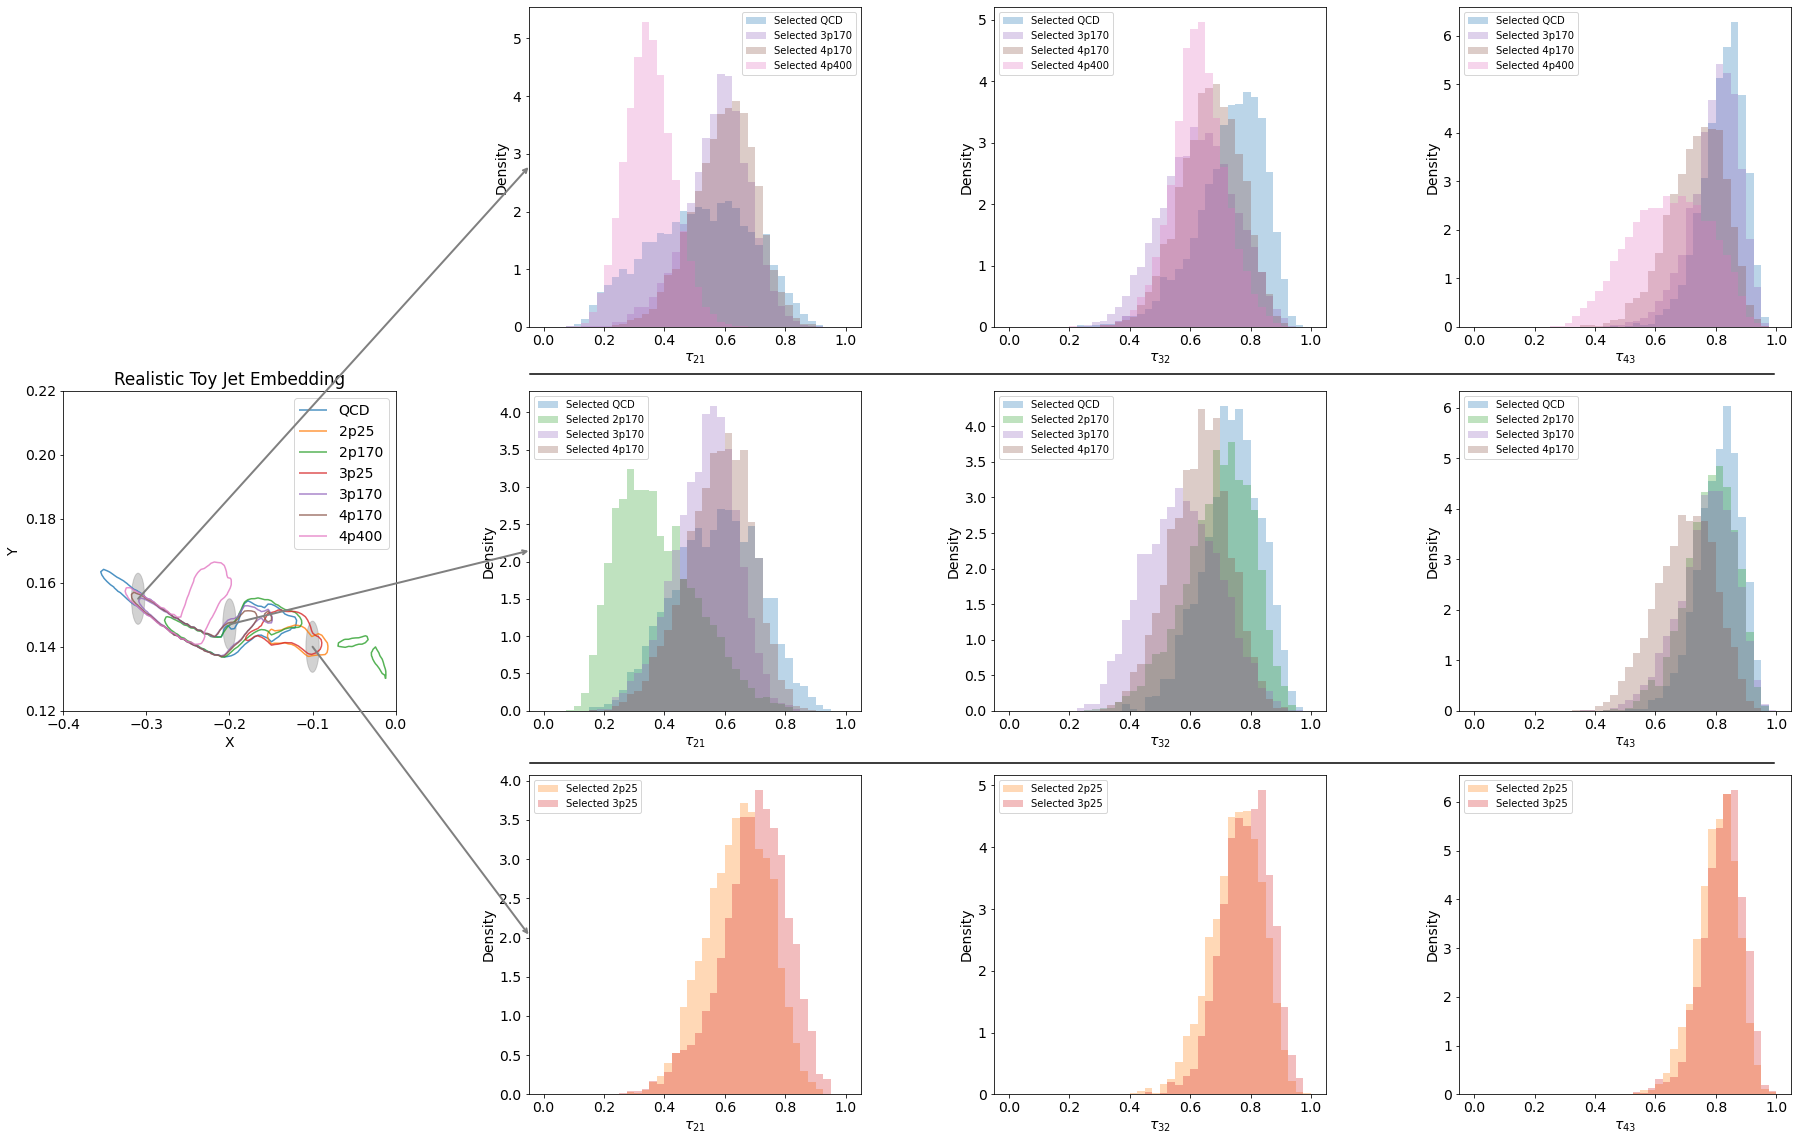

In [33]:
fig = plt.figure(constrained_layout=False, facecolor='1.',  figsize=(24,20))
gs = fig.add_gridspec(nrows=3, ncols=4, left=0., right=1.,
                      hspace=0.2, wspace=0.4)
ax0 = fig.add_subplot(gs[1, 0])

lines = []
for i in range(7):
    CS = plot_KDE_cdf_contour(ax0, i,0.8, f'C{i}')
    lines.append(CS.collections[0])


ax0.set_xlabel('X')
ax0.set_ylabel('Y')
ax0.set_xlim([-0.4,0.0])
ax0.set_ylim([0.12,0.22])
ax0.legend(lines, namelist)
ax0.set_title('Realistic Toy Jet Embedding')  


ax1 = fig.add_subplot(gs[0, 1])

ax2 = fig.add_subplot(gs[1, 1])

ax3 = fig.add_subplot(gs[2, 1])

ax4 = fig.add_subplot(gs[0, 2])

ax5 = fig.add_subplot(gs[1, 2])

ax6 = fig.add_subplot(gs[2, 2])

ax7 = fig.add_subplot(gs[0, 3])

ax8 = fig.add_subplot(gs[1, 3])

ax9 = fig.add_subplot(gs[2, 3])
plot_circle_and_fill_hist(ax0, ax7, ax1, ax4,  (-0.31,0.155), 0.008,'grey',[0,4,5,6])
plot_circle_and_fill_hist(ax0, ax8, ax2, ax5,  (-0.2,0.147), 0.008,'grey',[0,2,4,5])
plot_circle_and_fill_hist(ax0, ax9, ax3, ax6,  (-0.1,0.14), 0.008,'grey',[1,3])


con = ConnectionPatch(xyA=(-0.31,0.155), xyB=(0,0.5), coordsA="data", coordsB="axes fraction",
                              axesA=ax0, axesB=ax1, color="grey", lw=2, arrowstyle='->')
fig.add_artist(con)
con = ConnectionPatch(xyA=(-0.2,0.147), xyB=(0,0.5), coordsA="data", coordsB="axes fraction",
                              axesA=ax0, axesB=ax2, color="grey", lw=2, arrowstyle='->')
fig.add_artist(con)
con = ConnectionPatch(xyA=(-0.1,0.14), xyB=(0,0.5), coordsA="data", coordsB="axes fraction",
                              axesA=ax0, axesB=ax3, color="grey", lw=2, arrowstyle='->')
fig.add_artist(con)

ys = [0.355,0.625]
for y in ys:
    line = plt.Line2D([0.27,0.99],[y,y], transform=fig.transFigure, color="black")
    fig.add_artist(line)

In [34]:
fig.savefig(f'../figures/paper/Embedding_whatislearned_simulatedjets.png')    
fig.savefig(f'../figures/paper/Embedding_whatislearned_simulatedjets.pdf')    


In [272]:
def plot_circle_and_fill_hist(ax_i, ax_j, center, radius, color):
    
    circle1 = Circle(center, radius, color=color, alpha=0.2)
    diff = embedding - np.tile(np.array(center), (800000,1))
    dist = np.sqrt(np.sum(diff*diff, axis =1))
    indices = np.where(dist<radius)
    selected_z = predict_z[indices[0]]
    selected_theta = predict_theta[indices[0]]
    labelselected = label[indices[0]]
    ax_i.add_patch(circle1)
    ax_j.hist(predict_theta[:,0],density=True,alpha=0.3, label='original mixture')
    ax_j.hist(selected_theta[labelselected==2,0],density=True,alpha=0.3, label='selected twoprong')
    ax_j.hist(selected_theta[labelselected==3,0],density=True,alpha=0.3, label='selected threeprong')
    ax_j.hist(selected_theta[labelselected==4,0],density=True,alpha=0.3, label='selected fourprong')
    ax_j.set_xlabel(r'Theta')
    ax_j.set_ylabel(r'Density')

    ax_j.legend(fontsize=10)

    return None

    

In [239]:
indices = plot_circle_and_fill_hist(ax0, ax2, (0.05,0.1),.04,'grey')

indices = plot_circle_and_fill_hist(ax, (0.17,0.03),.04,'grey')

In [248]:
selected_z = predict_z[indices[0]]
selected_theta = predict_theta[indices[0]]
labelselected = label[indices[0]]

(array([2.91320128e+00, 3.22544495e+00, 4.53719028e+00, 6.41387133e+00,
        8.42896967e+00, 8.70580427e+00, 6.90798889e+00, 2.92929631e-01,
        0.00000000e+00, 1.60950347e-03]),
 array([3.25061353e-06, 2.41420915e-02, 4.82809325e-02, 7.24197734e-02,
        9.65586143e-02, 1.20697455e-01, 1.44836296e-01, 1.68975137e-01,
        1.93113978e-01, 2.17252819e-01, 2.41391660e-01]),
 <BarContainer object of 10 artists>)

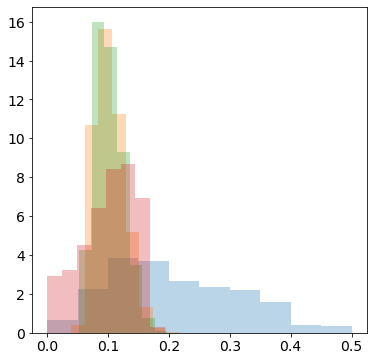

In [243]:
plt.hist(predict_z[:,0],density=True,alpha=0.3)
#plt.hist(predict_z[indices[0],0],density=True,alpha=0.3)
#plt.hist(selected_z[labelselected==1,0],density=True,alpha=0.3)
plt.hist(selected_z[labelselected==2,0],density=True,alpha=0.3)
plt.hist(selected_z[labelselected==3,0],density=True,alpha=0.3)
plt.hist(selected_z[labelselected==4,0],density=True,alpha=0.3)

(array([1.98808566e-03, 2.21529545e-02, 1.63875061e-01, 6.80777332e-01,
        1.40784866e+00, 1.99859411e+00, 2.67369120e+00, 3.48170601e+00,
        3.91766480e+00, 3.83956143e+00]),
 array([0.9209671 , 0.97594883, 1.03093056, 1.08591229, 1.14089402,
        1.19587575, 1.25085748, 1.30583921, 1.36082094, 1.41580268,
        1.47078441]),
 <BarContainer object of 10 artists>)

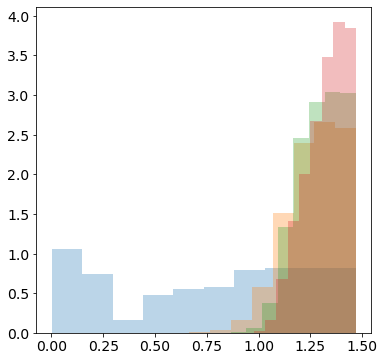

In [250]:
plt.hist(predict_theta[:,0],density=True,alpha=0.3)
#plt.hist(predict_z[indices[0],0],density=True,alpha=0.3)
#plt.hist(selected[labelselected==1],density=True,alpha=0.3)
plt.hist(selected_theta[labelselected==2,0],density=True,alpha=0.3)
plt.hist(selected_theta[labelselected==3,0],density=True,alpha=0.3)
plt.hist(selected_theta[labelselected==4,0],density=True,alpha=0.3)

(array([0.70926115, 0.74611324, 0.736475  , 0.74469586, 0.70897767,
        0.74016021, 0.72286807, 0.71322983, 0.74838106, 0.72626981]),
 array([0.10002037, 0.23707366, 0.37412695, 0.51118024, 0.64823353,
        0.78528682, 0.92234011, 1.0593934 , 1.19644669, 1.33349998,
        1.47055327]),
 <BarContainer object of 10 artists>)

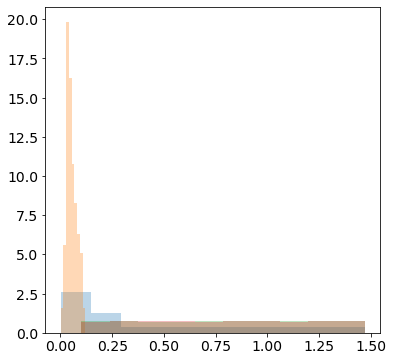

In [246]:
plt.hist(predict_theta[:,1],density=True,alpha=0.3)
#plt.hist(predict_z[indices[0],0],density=True,alpha=0.3)
#plt.hist(selected[labelselected==1],density=True,alpha=0.3)
plt.hist(selected_theta[labelselected==2,1],density=True,alpha=0.3)
plt.hist(selected_theta[labelselected==3,1],density=True,alpha=0.3)
plt.hist(selected_theta[labelselected==4,1],density=True,alpha=0.3)

(array([ 46.46021551,  65.72506318,  68.77796254,  75.02412445,
         82.67391824,  89.76225928, 100.67549721, 114.74690689,
        130.11667607, 129.23940614]),
 array([0.48892781, 0.49003498, 0.49114216, 0.49224933, 0.4933565 ,
        0.49446367, 0.49557084, 0.49667802, 0.49778519, 0.49889236,
        0.49999953]),
 <BarContainer object of 10 artists>)

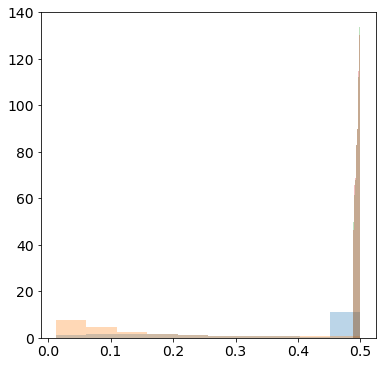

In [245]:
plt.hist(predict_z[:,1],density=True,alpha=0.3)
#plt.hist(predict_z[indices[0],0],density=True,alpha=0.3)
#plt.hist(selected[labelselected==1],density=True,alpha=0.3)
plt.hist(selected_z[labelselected==2,1],density=True,alpha=0.3)
plt.hist(selected_z[labelselected==3,1],density=True,alpha=0.3)
plt.hist(selected_z[labelselected==4,1],density=True,alpha=0.3)

In [136]:
predict_z[:,0]

array([0.40309423, 0.2621194 , 0.4759691 , ..., 0.26266149, 0.14370487,
       0.05567405])

In [108]:
plot_circle_and_fill_hist(ax, (0.3,0.19),.04,'C1')

In [109]:
plot_circle_and_fill_hist(ax, (0.17,0.03),.04,'C2')

In [112]:
embedding.shape

(800000, 2)

In [117]:
np.tile([0.02,0.23],(800000,1))

array([[0.02, 0.23],
       [0.02, 0.23],
       [0.02, 0.23],
       ...,
       [0.02, 0.23],
       [0.02, 0.23],
       [0.02, 0.23]])

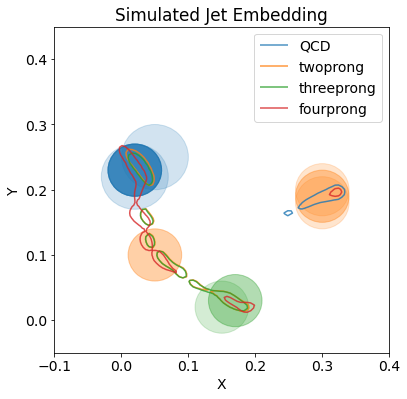

In [210]:
fig

In [69]:
ax_c

<AxesSubplot:xlabel='X', ylabel='Y'>

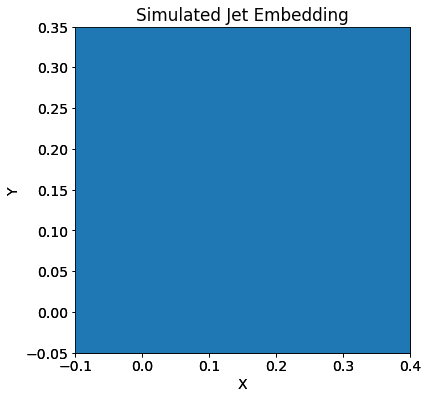

In [70]:
fig